In [1]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Bio import SeqIO

import passenger

In [2]:
blast_paths = glob("passenger-blast/outname_*.tsv")
#prefix = "8a"
#mut_freq_name = prefix+"_mut_freq"
chigy = passenger.CHIGY_HC
max_mutation_count = 10
max_n_count = 10
# 2 or 3 gap segments, which corresponds to 0 or 1 indels
allowable_gap_segment_counts = [2, 3]

In [3]:
passenger.test_summarize_alignment()
passenger.test_correct_alignment()
passenger.test_summarize_alignment()
passenger.test_compute_mutation_counts_by_base()

Text(0.5, 1.0, 'Histogram of CONSCOUNT values for input/outname_5_S1_R1_001_atleast-2.fastq.gz')

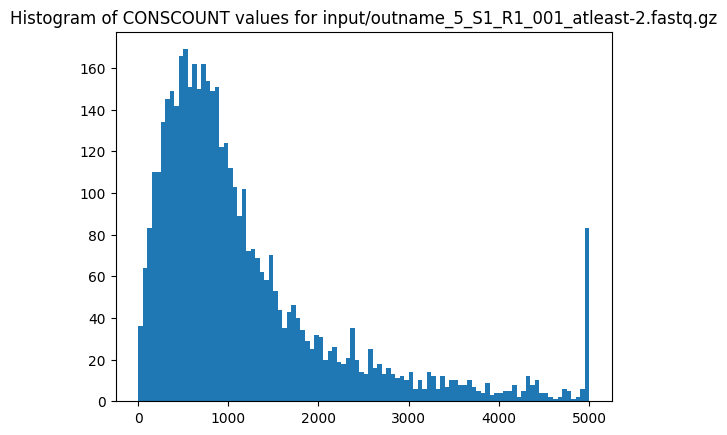

In [4]:
import re, gzip
pattern = re.compile(r"CONSCOUNT=(\d+)")

fastq_gz_path = "input/outname_5_S1_R1_001_atleast-2.fastq.gz"

max_count = 5000

conscount_values = []
conscount_truncated = []
sequence_lengths = []

# Parse the fastq file
with gzip.open(fastq_gz_path, "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        sequence_lengths.append(len(record.seq))
        match = pattern.search(record.description)
        if match:
            conscount = int(match.group(1))
            # All values greater than max_count are set to max_count
            conscount_values.append(conscount)
            conscount_truncated.append(min(conscount, max_count))

# Create a pandas Series
conscount_series = pd.Series(conscount_values)
#print(conscount_series.describe())
# plt.hist(conscount_series) with log scale on x-axis
plt.hist(conscount_truncated, bins=100, range=(0, max_count + 1))
# set title to "Histogram of CONSCOUNT values"
plt.title(f"Histogram of CONSCOUNT values for {fastq_gz_path}")

Text(0.5, 1.0, 'Histogram of sequence lengths for input/outname_5_S1_R1_001_atleast-2.fastq.gz')

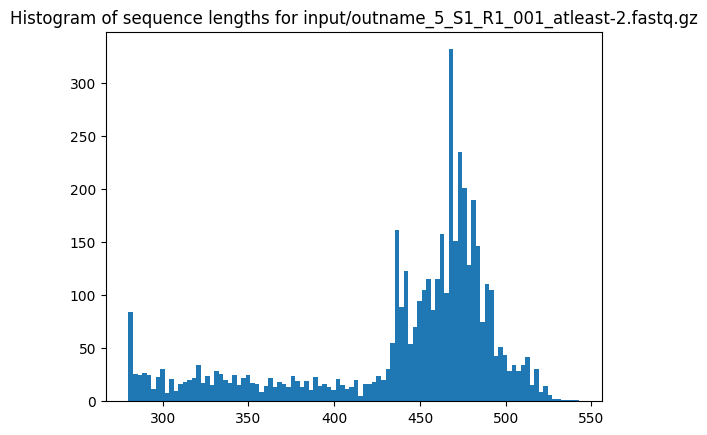

In [5]:
# make histogram of sequence lengths
plt.hist(sequence_lengths, bins=100)
plt.title(f"Histogram of sequence lengths for {fastq_gz_path}")

In [6]:
blast_df = passenger.blast_df_of_blast_files(blast_paths)

duplicates = blast_df[blast_df.duplicated("subject")].copy()
duplicates.sort_values("subject", inplace=True)
duplicates.reset_index(drop=True).loc[0, "subject"]

Original length: 5591
Unique length: 5590
Duplicated sequences:
AGGAGAACAACAAAACG|PRCONS=Mus-p5-IgGa|CONSCOUNT=2|DUPCOUNT=1
AGGAGAACAACAAAACG|PRCONS=Mus-p5-IgGa|CONSCOUNT=2|DUPCOUNT=1


'AGGAGAACAACAAAACG|PRCONS=Mus-p5-IgGa|CONSCOUNT=2|DUPCOUNT=1'

In [7]:
with gzip.open("input/outname_6A_S2_R1_001_atleast-2.fastq.gz", "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        if "AGGAGAACAACAAAACG|PRCONS=Mus-p5-IgGa|CONSCOUNT=2|DUPCOUNT=1" in record.description:
            print(record.seq)

# We can see that this matches "AACCGGTGTGTACATTCCGA" twice.

GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTACATTCCGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGCCAAAACAACAGCCCCATCNGTCTATCCACTGGAGATCGGAAGAGCGTCGTGGTGGGAAANAGTGTGNTTCGATCTAGGAGAACAAAAAAACGGATCTACGGGGACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTACATTCCGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGCCAAAACAACAG


In [8]:
single_blast_df = passenger.read_blast_file(blast_paths[-1])

# find rows with duplicate "subject" values
# (these are the rows with multiple hits)
duplicates = single_blast_df[single_blast_df.duplicated("subject")]
duplicates.sort_values("subject", inplace=True)
duplicates.reset_index(drop=True).loc[0, "subject"]


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_59588/3703944832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.sort_values("subject", inplace=True)


'AAACATGGCGAAAGGGT|PRCONS=Mus-p5-IgM|CONSCOUNT=2|DUPCOUNT=1'

In [9]:
blast_df.sort_values("dataset", inplace=True)

read_comparison_df = pd.DataFrame(blast_df["dataset"].value_counts().sort_index())
read_comparison_df.rename(columns={"count": "chigy_count"}, inplace=True)
read_comparison_df["fasta_count"] = 0

for dataset in read_comparison_df.index:
    fasta_path = f"passenger-blast/{dataset}.fasta"
    # count the number of reads in the fasta file
    read_comparison_df.loc[dataset, "fasta_count"] = len(list(SeqIO.parse(fasta_path, "fasta")))

read_comparison_df["chigy_fraction"] = read_comparison_df["chigy_count"] / read_comparison_df["fasta_count"]

read_comparison_df

,chigy_count,fasta_count,chigy_fraction
dataset,,,
outname_5_S1_R1_001_atleast-2,960,4539,0.21150
outname_6A_S2_R1_001_atleast-2,2433,8123,0.29952
outname_7B_S3_R1_001_atleast-2,2198,7715,0.28490


In [10]:
processed_stop_df = chigy.processed_stop_df_of_blast_df(blast_df)
# processed_stop_df

processed_stop_df["dataset"].value_counts().sort_index()

dataset
outname_5_S1_R1_001_atleast-2      960
outname_6A_S2_R1_001_atleast-2    2433
outname_7B_S3_R1_001_atleast-2    2198
Name: count, dtype: int64

In [11]:
processed_stop_df["mutation_count"].value_counts()[:20].sort_index()

mutation_count
0       607
1      1391
2      1076
3       782
4       561
5       368
6       236
7       166
8        88
9        66
10       29
11       13
12       13
13        4
15        5
86        4
105       4
112       4
122       5
127       5
Name: count, dtype: int64

In [12]:
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] < max_mutation_count) & (processed_stop_df["n_count"] < max_n_count) & (processed_stop_df["bookended_by_gaps"] == True)].copy()

chigy_believable


,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,...,dataset,sequence,gap_segment_count,bookended_by_gaps,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
2771,AAGGTTCACCCTAGGGG|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,76,95,0.000013,...,outname_5_S1_R1_001_atleast-2,GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCA...,2,True,"[175, 226, 280, 285]","[T, T, G, A]",[],4,0,2771
2770,ATCCGAGCGAGTAGACG|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,100,119,0.000013,...,outname_5_S1_R1_001_atleast-2,GGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTC...,2,True,"[84, 129]","[G, C]",[],2,0,2770
2764,GAATTATCTGGTAAGCT|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,108,127,0.000013,...,outname_5_S1_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,"[140, 179]","[G, A]",[],2,0,2764
2763,TCACATGGGATATACAG|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,108,127,0.000013,...,outname_5_S1_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,"[173, 199, 232]","[T, A, T]",[],3,0,2763
2762,TACCAAAGCTGTAAACG|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,76,95,0.000013,...,outname_5_S1_R1_001_atleast-2,GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCA...,2,True,[],[],[],0,0,2762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,ACAGGAGAGGGAGGAAT|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,80,99,0.000022,...,outname_7B_S3_R1_001_atleast-2,GTCTCAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATG...,2,True,"[8, 139]","[T, T]",[],2,0,1480
1479,AAAAAAGGGCAAAAAAA|PRCONS=Mus-p5-IgM|CONSCOUNT=...,100.0,20,0,0,1,20,108,127,0.000022,...,outname_7B_S3_R1_001_atleast-2,GACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,"[122, 158, 163, 166]","[T, T, A, A]",[],4,0,1479
1478,ACGACATTAATTGATTG|PRCONS=Mus-p5-IgGb|CONSCOUNT...,100.0,20,0,0,1,20,107,126,0.000022,...,outname_7B_S3_R1_001_atleast-2,ACATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGA...,2,True,"[72, 129]","[T, G]",[],2,0,1478
1484,CAAGATATTTGAGGTAT|PRCONS=Mus-p5-IgGb|CONSCOUNT...,100.0,20,0,0,1,20,100,119,0.000022,...,outname_7B_S3_R1_001_atleast-2,GGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTC...,2,True,"[114, 246]","[G, C]",[],2,0,1484


In [13]:
# Find representatives of the various gap counts
representative_gap_counts = chigy_believable.drop_duplicates(subset=["gap_segment_count"])
representative_gap_counts = representative_gap_counts.sort_values(by=["gap_segment_count"])
chigy.pretty_print_alignments(representative_gap_counts)

> outname_5_S1_R1_001_atleast-2 2771
---------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG-------
                                                                                             |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||.||||.|||||||||||||||||||||||||||||||||||||||||||||||||||       
GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTA

In [14]:
chigy_believable = chigy_believable[chigy_believable["gap_segment_count"].isin(allowable_gap_segment_counts)]
chigy_believable["mutation_count"].value_counts().sort_index()

mutation_count
0     471
1    1089
2     821
3     583
4     414
5     268
6     166
7     119
8      55
9      52
Name: count, dtype: int64

In [15]:
chigy_believable["dataset"].value_counts().sort_index()

dataset
outname_5_S1_R1_001_atleast-2      722
outname_6A_S2_R1_001_atleast-2    1749
outname_7B_S3_R1_001_atleast-2    1567
Name: count, dtype: int64

In [16]:
conscounts = chigy_believable["subject"].str.findall(r"CONSCOUNT=(\d+)").apply(lambda x: int(x[0]) if x else 0)
pd.DataFrame({"subject": chigy_believable["subject"], "conscount": conscounts, "n_count": chigy_believable["n_count"]}).to_csv("output/igh-conscount-vs-n-count.csv", index=False)

In [17]:
# Find representatives of the various gap counts
representative_mutation_counts = chigy_believable.drop_duplicates(subset=["mutation_count"])
representative_mutation_counts = representative_mutation_counts.sort_values(by=["mutation_count"])
chigy.pretty_print_alignments(representative_mutation_counts)

> outname_5_S1_R1_001_atleast-2 2762
---------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG-------
                                                                                             |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||       
GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCATGTATCATCCTTTTTCTAGTAGCAACTGCAACCGGTGTGTA

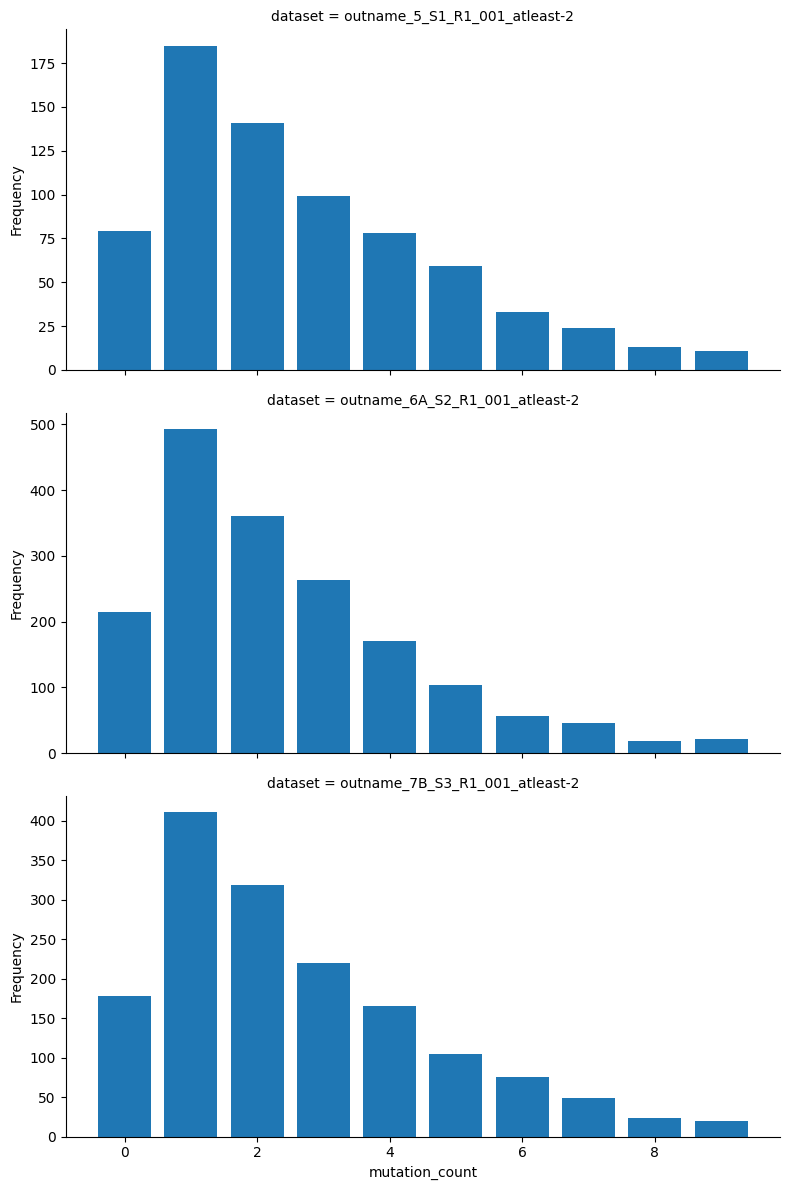

In [18]:
passenger.make_mutation_histogram(chigy_believable)

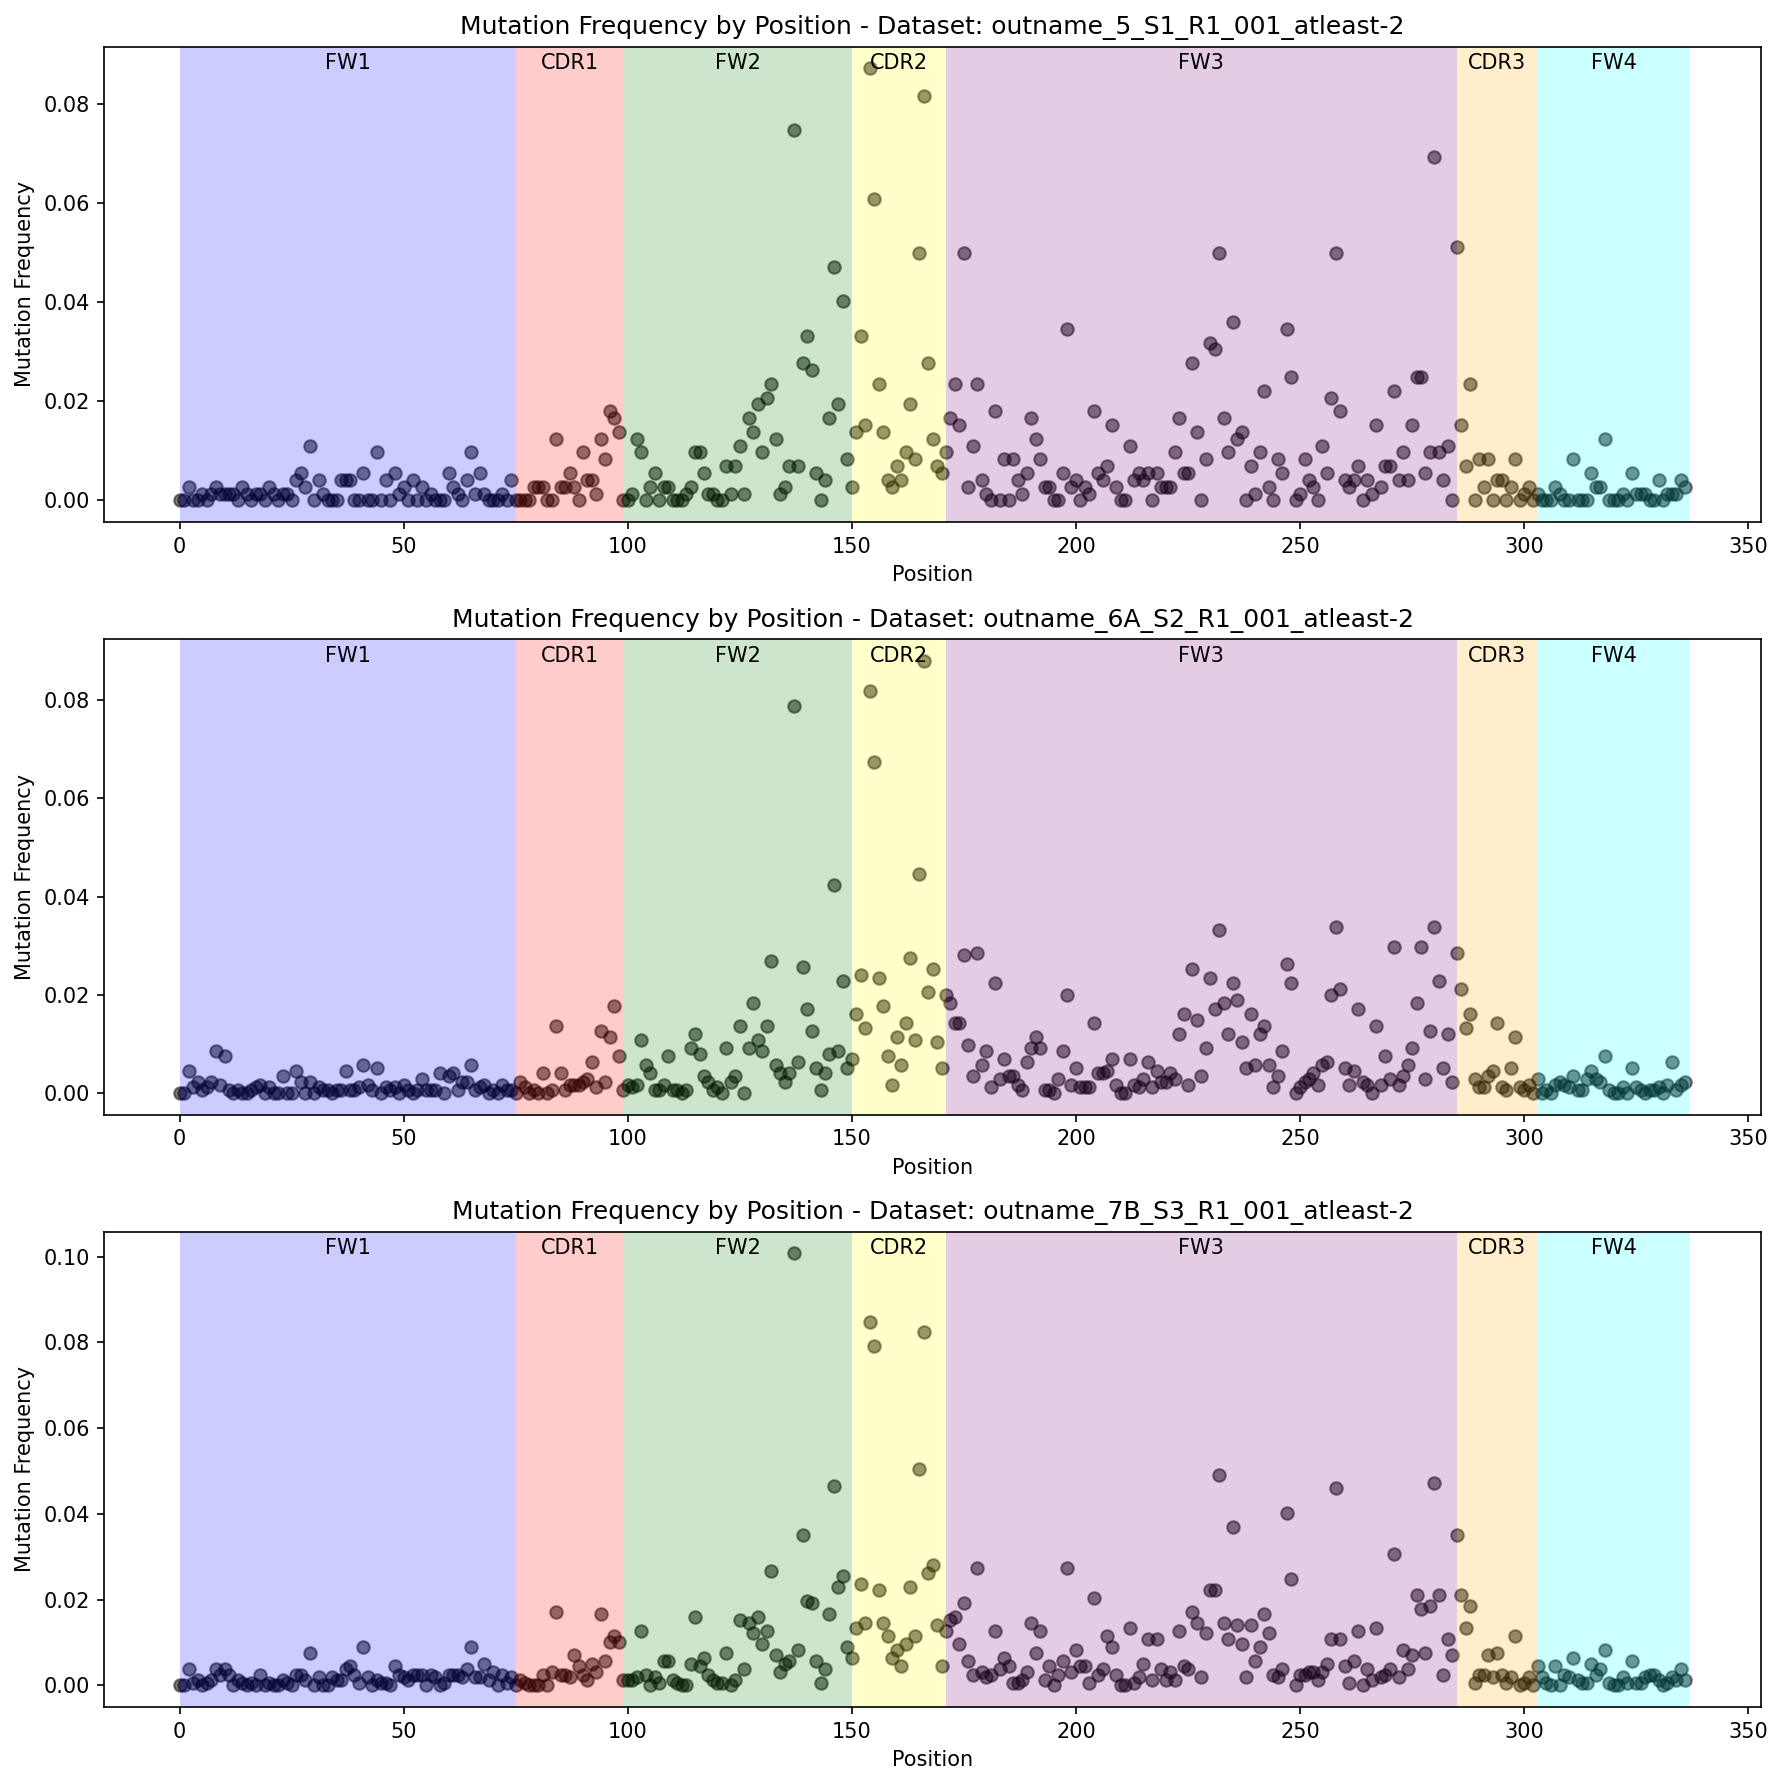

In [19]:
chigy.make_mutation_rate_plot(chigy_believable)


In [20]:
mut_counts_l = []
read_counts_l = []

for name, df in chigy_believable.groupby("dataset"):
    mut_counts = passenger.compute_mutation_counts_by_base(df, chigy.chigy_stop_trimmed)
    nickname = name[8:13]
    # trim off a trailing underscore if it exists
    if nickname[-1] == "_":
        nickname = nickname[:-1]
    mut_counts["nickname"] = nickname
    mut_counts_l.append(mut_counts)
    read_counts_l.append({"nickname": nickname, "read_count": len(df)})

read_counts_df = pd.DataFrame(read_counts_l)
read_counts_df.to_csv("output/igh_read_counts.csv", index=False)

mut_counts_df = pd.concat(mut_counts_l)
mut_counts_df.reset_index(names=["position"], inplace=True)
mut_counts_df = mut_counts_df[["nickname", "position", "A", "C", "G", "T"]]
mut_counts_df.to_csv("output/igh_counts_by_base.csv", index=False)
mut_counts_df

,nickname,position,A,C,G,T
0,5_S1,0,0,0,-1,0
1,5_S1,1,-1,0,0,0
2,5_S1,2,2,0,-1,0
3,5_S1,3,0,0,-1,0
4,5_S1,4,0,0,0,-1
...,...,...,...,...,...,...
1006,7B_S3,332,0,-1,1,0
1007,7B_S3,333,0,0,3,-1
1008,7B_S3,334,0,-1,1,1
1009,7B_S3,335,-1,2,1,3


In [21]:
mutation_frequency_by_position = passenger.mutation_frequency_by_position_of(chigy_believable)
n_frequency_by_position = passenger.compute_thing_counts(chigy_believable, "n_positions") / len(chigy_believable)
# pad np array n_frequency_by_position with zeros to be as long as mutation_frequency_by_position
n_frequency_by_position = np.pad(n_frequency_by_position, (0, len(mutation_frequency_by_position) - len(n_frequency_by_position)))
mut_freq_df = pd.DataFrame({
    "mutation_frequency": mutation_frequency_by_position, 
    "N_frequency": n_frequency_by_position
})
mut_freq_df.to_csv("output/igh_n_frequency.csv", columns=["N_frequency"], index=False)
n_rich_df = mut_freq_df[mut_freq_df["N_frequency"] > 0.]
n_rich_df = n_rich_df.sort_values(by="mutation_frequency", ascending=False)
n_rich_df

,mutation_frequency,N_frequency
166,0.084695,0.000248
165,0.047796,0.000248
285,0.035166,0.000248
271,0.028727,0.000248
168,0.024022,0.000248
140,0.021050,0.000248
276,0.020555,0.000248
242,0.016345,0.000248
171,0.015354,0.000248
145,0.012878,0.000248


<Axes: xlabel='N_frequency', ylabel='mutation_frequency'>

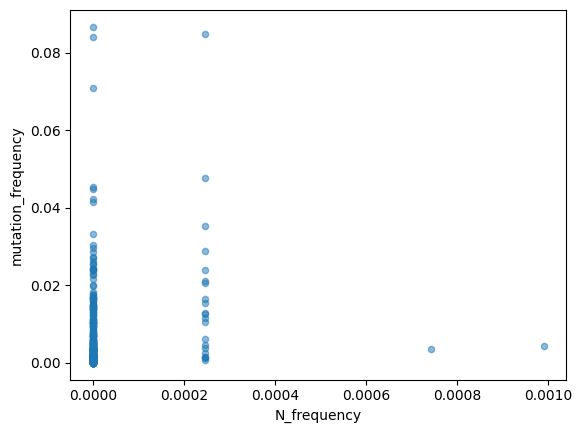

In [22]:
mut_freq_df.plot.scatter(x="N_frequency", y="mutation_frequency", alpha=0.5)